In [6]:
!unzip noisy-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy-images/20236.jpg  
  inflating: noisy-images/49375.jpg  
  inflating: noisy-images/14050.jpg  
  inflating: noisy-images/40483.jpg  
  inflating: noisy-images/37230.jpg  
  inflating: noisy-images/57520.jpg  
  inflating: noisy-images/8022.jpg   
  inflating: noisy-images/9633.jpg   
  inflating: noisy-images/12046.jpg  
  inflating: noisy-images/34432.jpg  
  inflating: noisy-images/9543.jpg   
  inflating: noisy-images/26942.jpg  
  inflating: noisy-images/43224.jpg  
  inflating: noisy-images/55124.jpg  
  inflating: noisy-images/25079.jpg  
  inflating: noisy-images/28446.jpg  
  inflating: noisy-images/20772.jpg  
  inflating: noisy-images/26843.jpg  
  inflating: noisy-images/9673.jpg   
  inflating: noisy-images/19785.jpg  
  inflating: noisy-images/27456.jpg  
  inflating: noisy-images/8864.jpg   
  inflating: noisy-images/46909.jpg  
  inflating: noisy-images/17494.jpg  
  inflating: noisy-images/48774.jpg  

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [3]:
df = pd.read_csv('train.csv')[['id', 'category']]

c_to_i = {}
i_to_c = {}
for i, c in enumerate(df['category'].unique()):
    c_to_i[c] = i
    i_to_c[i] = c

num_categories = len(c_to_i)
print(num_categories)

# df = df.sample(frac=1).reset_index(drop=True)

df_train, df_val = train_test_split(df, train_size=0.8)

27


In [4]:
class ImageData(Dataset):
    def __init__(self, df, transform=None, target_transform=None, test=False):
        self.df = df
    
        self.image_dir = 'noisy-images'
        self.transform = transform
        self.target_transform = target_transform
        self.len = len(df)
        self.test = test

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, str(self.df.iloc[idx]['id']) + '.jpg')
        image = read_image(img_path).type(torch.float)

        if self.transform:
            image = self.transform(image)

        if self.test:
            return image
        else:
            category = self.df.iloc[idx]['category']
            label = c_to_i[category]

            if self.target_transform:
                label = self.target_transform(label)

            return image, label

    def __len__(self):
        return self.len

data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop((80, 60)),
        transforms.RandomHorizontalFlip(),
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = ImageData(df_train, transform=data_transforms['train'])
val_dataset = ImageData(df_val, transform=data_transforms['val'])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)

/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Feature batch shape: torch.Size([64, 3, 80, 60])
Labels batch shape: torch.Size([64])
Feature 0: tensor([[[1059.0175, 1075.7205, 1098.8646,  ..., 1053.9227, 1054.6506,
          1054.6506],
         [1073.6462, 1085.6864, 1102.1407,  ..., 1045.1606, 1045.5077,
          1045.5077],
         [1090.5404, 1095.8761, 1102.7992,  ..., 1032.5210, 1031.7999,
          1031.4519],
         ...,
         [1089.0393, 1092.8091, 1097.7217,  ..., 1109.5315, 1110.5254,
          1110.8733],
         [1087.0469, 1090.7588, 1095.5986,  ..., 1090.9907, 1089.6541,
          1088.5754],
         [1085.2184, 1088.9302, 1093.7700,  ..., 1076.6666, 1073.9738,
          1072.1179]],

        [[1091.7142, 1104.9956, 1123.3363,  ..., 1064.5565, 1064.9286,
          1064.9286],
         [1108.5391, 1117.0532, 1128.7888,  ..., 1059.1819, 1059.3202,
          1059.3203],
         [1128.6842, 1130.7001, 1133.4915,  ..., 1051.5125, 1050.7754,
          1050.4197],
         ...,
         [1131.6139, 1133.6296, 1136

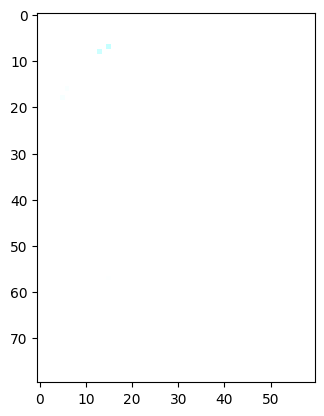

Label: 2


In [7]:
train_features, train_labels = next(iter(train_dataloader))

print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
print(f'Feature 0: {train_features[0]}')

img = torch.movedim(train_features[0], 0, 2).int()
label = train_labels[0]
plt.imshow(img)
plt.show()

print(f'Label: {label}')

In [24]:
resnet_model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
for param in resnet_model.parameters():
    param.requires_grad = False

# resnet_model.fc = nn.Linear(512, num_categories)
resnet_model.fc = nn.Linear(2048, num_categories)

resnet_model = resnet_model.to(device)

In [25]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

def train_full(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs=10, save_weights=False):
    train_accuracies, val_accuracies = [], []
    top_val_accuracy = 0.0

    for t in tqdm(range(epochs)):
        train_accuracy, train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        train_accuracies += [train_accuracy]

        val_accuracy, val_loss = test_epoch(val_dataloader, model, loss_fn)
        val_accuracies += [val_accuracy]

        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            if save_weights:
                torch.save(model, 'resnet_model.pth')

        print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {train_loss:>6f}\t Val accuracy: {100*val_accuracy:0.1f}%\t Avg val loss: {val_loss:>6f}")

    return train_accuracies, val_accuracies

In [ ]:
%%time

save_weights = True
load_weights = False
num_epochs = 25

if load_weights:
    resnet_model = torch.load('resnet_model.pth')

loss_fn = nn.CrossEntropyLoss()
params_to_update = []
for name, param in resnet_model.named_parameters():
    if param.requires_grad:
        params_to_update.append(param)
        print(name)

optimizer = torch.optim.Adam(params=params_to_update)

train_accuracies, val_accuracies = train_full(train_dataloader, val_dataloader, resnet_model, loss_fn, optimizer, epochs=num_epochs, save_weights=save_weights)

fc.weight
fc.bias


  0%|          | 0/25 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
  4%|▍         | 1/25 [00:31<12:26, 31.09s/it]

Epoch 1:	 Train accuracy: 55.0%	 Avg train loss: 1.767511	 Val accuracy: 58.9%	 Avg val loss: 1.643348


  8%|▊         | 2/25 [01:03<12:14, 31.94s/it]

Epoch 2:	 Train accuracy: 59.4%	 Avg train loss: 1.589026	 Val accuracy: 59.9%	 Avg val loss: 1.585723


 12%|█▏        | 3/25 [01:34<11:33, 31.54s/it]

Epoch 3:	 Train accuracy: 60.5%	 Avg train loss: 1.512413	 Val accuracy: 60.2%	 Avg val loss: 1.567971


 16%|█▌        | 4/25 [02:05<10:54, 31.17s/it]

Epoch 4:	 Train accuracy: 61.3%	 Avg train loss: 1.492605	 Val accuracy: 60.4%	 Avg val loss: 1.572575


 20%|██        | 5/25 [02:37<10:30, 31.55s/it]

Epoch 5:	 Train accuracy: 61.5%	 Avg train loss: 1.476898	 Val accuracy: 59.0%	 Avg val loss: 1.619822


 24%|██▍       | 6/25 [03:07<09:51, 31.11s/it]

Epoch 6:	 Train accuracy: 62.2%	 Avg train loss: 1.455212	 Val accuracy: 60.1%	 Avg val loss: 1.574168


 28%|██▊       | 7/25 [03:39<09:21, 31.21s/it]

Epoch 7:	 Train accuracy: 62.5%	 Avg train loss: 1.451578	 Val accuracy: 60.4%	 Avg val loss: 1.558665


 32%|███▏      | 8/25 [04:09<08:46, 30.95s/it]

Epoch 8:	 Train accuracy: 62.4%	 Avg train loss: 1.441672	 Val accuracy: 60.6%	 Avg val loss: 1.566614


 36%|███▌      | 9/25 [04:41<08:19, 31.21s/it]

Epoch 9:	 Train accuracy: 62.3%	 Avg train loss: 1.446130	 Val accuracy: 60.0%	 Avg val loss: 1.583304


 40%|████      | 10/25 [05:11<07:43, 30.87s/it]

Epoch 10:	 Train accuracy: 63.1%	 Avg train loss: 1.417645	 Val accuracy: 59.8%	 Avg val loss: 1.579454


 44%|████▍     | 11/25 [05:42<07:11, 30.79s/it]

Epoch 11:	 Train accuracy: 62.4%	 Avg train loss: 1.437786	 Val accuracy: 59.5%	 Avg val loss: 1.572289


 48%|████▊     | 12/25 [06:11<06:34, 30.33s/it]

Epoch 12:	 Train accuracy: 62.9%	 Avg train loss: 1.426669	 Val accuracy: 60.4%	 Avg val loss: 1.554989


 52%|█████▏    | 13/25 [06:40<05:59, 29.92s/it]

Epoch 13:	 Train accuracy: 62.6%	 Avg train loss: 1.423736	 Val accuracy: 57.5%	 Avg val loss: 1.625434


 56%|█████▌    | 14/25 [07:11<05:31, 30.16s/it]

Epoch 14:	 Train accuracy: 62.3%	 Avg train loss: 1.430859	 Val accuracy: 59.7%	 Avg val loss: 1.566588


In [ ]:
resnet_model.eval()


def make_predictions(df):
    eval_dataset = ImageData(df, transform=data_transforms['val'], test=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False)

    predictions = []
    for _, X in enumerate(eval_dataloader):
        X = X.to(device)

        pred = resnet_model(X)
        labels = pred.argmax(1)
        for j in range(pred.shape[0]):
            predictions.append(i_to_c[labels[j].item()])

    return predictions

def eval_pred(base, pred):
    assert(base['id'].equals(pred['id']))
    print('ids match')
    diff_count = (base['category'] == pred['category']).value_counts()

    return (100.0*diff_count[True])/len(base)


In [ ]:
%%time

test_features = ['id']

df = pd.read_csv('train.csv')
train_pred = df[['id']]
train_pred['category'] = make_predictions(df)

print(f'train accuracy: {eval_pred(df, train_pred)}')

df_test = pd.read_csv('test.csv')
test_pred = df_test[['id']]
test_pred['category'] = make_predictions(df_test)
assert(df_test['id'].equals(test_pred['id']))

<timed exec>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ids match
train accuracy: 52.892218060757386
CPU times: user 7min 16s, sys: 33.8 s, total: 7min 50s
Wall time: 7min 53s


<timed exec>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
train_pred.to_csv('resnet_train_pred.csv', index=False)
test_pred.to_csv('resnet_test_pred.csv', index=False)